# Import Packages

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from gensim.models.word2vec import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



# Import Cleaned Data

In [ ]:
data_clean = pd.read_csv('bbt_data_clean.csv')
data_clean.sample(frac=1)
data_clean

,Unnamed: 0,season,episode,episode_name,speaker,dialogue
0,0,1,1,Pilot Episode,SHELDON,photon direct plane two slit either slit obser...
1,1,1,1,Pilot Episode,LEONARD,agree what’s point
2,2,1,1,Pilot Episode,SHELDON,there’s point think it’s good idea tee-shirt
3,3,1,1,Pilot Episode,LEONARD,excuse
4,4,1,1,Pilot Episode,LEONARD,one across aegean eight nabakov twenty-six acr...
...,...,...,...,...,...,...
45154,46636,10,24,The Long Distance Dissonance,SHELDON,uh breakfast yes lunch cough drop really rid l...
45155,46637,10,24,The Long Distance Dissonance,SHELDON,thoughtful thank
45156,46638,10,24,The Long Distance Dissonance,SHELDON,question seek romantic relationship
45157,46639,10,24,The Long Distance Dissonance,SHELDON,well would raise number problem we’re colleagu...


In [ ]:
# Select and Label Dataset for Modeling

In [ ]:
threshold = 7
names={0:'SHELDON', 1:'LEONARD', 2:'PENNY', 3:'HOWARD',4:'RAJ',5:"OTHERS"}
names_rev={'SHELDON':0, 'LEONARD':1, 'PENNY':2, 'HOWARD':3,'RAJ':4,"OTHERS":5}

data_thres = data_clean
data_thres['speaker']= data_clean['speaker'].apply(lambda x: 'OTHERS' if (x not in names.values()) else x)

data_thres['target'] = data_thres.apply(lambda x: names_rev.get(x.speaker),axis=1)
data_thres[:10]

,Unnamed: 0,season,episode,episode_name,speaker,dialogue,target
0,0,1,1,Pilot Episode,SHELDON,photon direct plane two slit either slit obser...,0
1,1,1,1,Pilot Episode,LEONARD,agree what’s point,1
2,2,1,1,Pilot Episode,SHELDON,there’s point think it’s good idea tee-shirt,0
3,3,1,1,Pilot Episode,LEONARD,excuse,1
4,4,1,1,Pilot Episode,LEONARD,one across aegean eight nabakov twenty-six acr...,1
5,5,1,1,Pilot Episode,LEONARD,yes um high iq sperm bank,1
6,6,1,1,Pilot Episode,SHELDON,think place,0
7,7,1,1,Pilot Episode,LEONARD,thank-you we’ll right back,1
8,8,1,1,Pilot Episode,SHELDON,leonard don’t think,0
9,9,1,1,Pilot Episode,LEONARD,kid you’re semi-pro,1


In [ ]:
# split the clean text in the rows  into list of words
tokenized_data = data_thres["dialogue"].apply(lambda text: re.split(' ',text))

target_thres = data_thres['target'] 
my_tags = data_thres['target'].unique()
my_tags

array([0, 1, 2, 3, 4, 5])

In [ ]:
data_thres.head()

,Unnamed: 0,season,episode,episode_name,speaker,dialogue,target
0,0,1,1,Pilot Episode,SHELDON,photon direct plane two slit either slit obser...,0
1,1,1,1,Pilot Episode,LEONARD,agree what’s point,1
2,2,1,1,Pilot Episode,SHELDON,there’s point think it’s good idea tee-shirt,0
3,3,1,1,Pilot Episode,LEONARD,excuse,1
4,4,1,1,Pilot Episode,LEONARD,one across aegean eight nabakov twenty-six acr...,1


# Feature Engineering using Bag of Words and Word2Vec Embedding

## Count Vectorizer

In [ ]:
# Create a BoW with Count Vectorizer 


def count_vectorizer(data):
    vectorizer = CountVectorizer(ngram_range = (1,2), min_df=10)
    # call `fit` to build the vocabulary
    vectorizer.fit(data)

    # call `transform` to convert text to a bag of words
    count_vectorizer_result  = vectorizer.transform(data)

    #convert to a numpy array to visualize as dataframe
    count_vectorizer_result = count_vectorizer_result.toarray()
    count_vectorizer_features = pd.DataFrame(count_vectorizer_result , columns = vectorizer.get_feature_names())
    count_vectorizer_features.index = data.index
    return count_vectorizer_features

count_vectorizer_df = count_vectorizer(data_thres['dialogue'])
count_vectorizer_df.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(45159, 4608)

## Train-Test Split

In [ ]:
Count_vectorizer_x_train, Count_vectorizer_x_test, Count_vectorizer_y_train, Count_vectorizer_y_test = train_test_split(count_vectorizer_df,target_thres,test_size = 0.2,random_state =42)

Count_vectorizer_x_train.shape

(36127, 4608)

## Plot Confusion Matrix

In [ ]:
def plot_cm(y_true, y_pred, figsize=(15, 15)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

## Saving Model to Disk

In [ ]:
import pickle
def save_model(model,filename):
  pickle.dump(model, open(filename+".sav", 'wb'))

# Logistic Regression

In [ ]:
# Cross-validation
def word_embedding_performance_eval(clf,X,Y):
    Eval_score =  cross_val_score(clf,X,Y, cv=5)
    return  Eval_score.mean() 
    
model =  LogisticRegression(max_iter = 1e6)
train_accuracy = word_embedding_performance_eval(model,Count_vectorizer_x_train,Count_vectorizer_y_train)
print("LR Train Accuracy", train_accuracy)

LR Train Accuracy 0.3285357125413132


## Accuracy for Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score
model_lr =  LogisticRegression(max_iter = 1e6)
model_lr.fit(Count_vectorizer_x_train,Count_vectorizer_y_train)
save_model(model_lr,"cv-lr-bbt")
y_pred = model_lr.predict(Count_vectorizer_x_test)
accuracy_score(Count_vectorizer_y_test, y_pred)


0.3330380868024801

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Count_vectorizer_y_test, y_pred)

array([[1573,  361,  150,   36,   15,   99],
       [ 651,  707,  255,   33,   13,  142],
       [ 429,  447,  433,   24,   10,  114],
       [ 399,  358,  135,   83,   18,  106],
       [ 360,  278,  111,   29,   57,   89],
       [ 611,  450,  188,   38,    9,  221]])

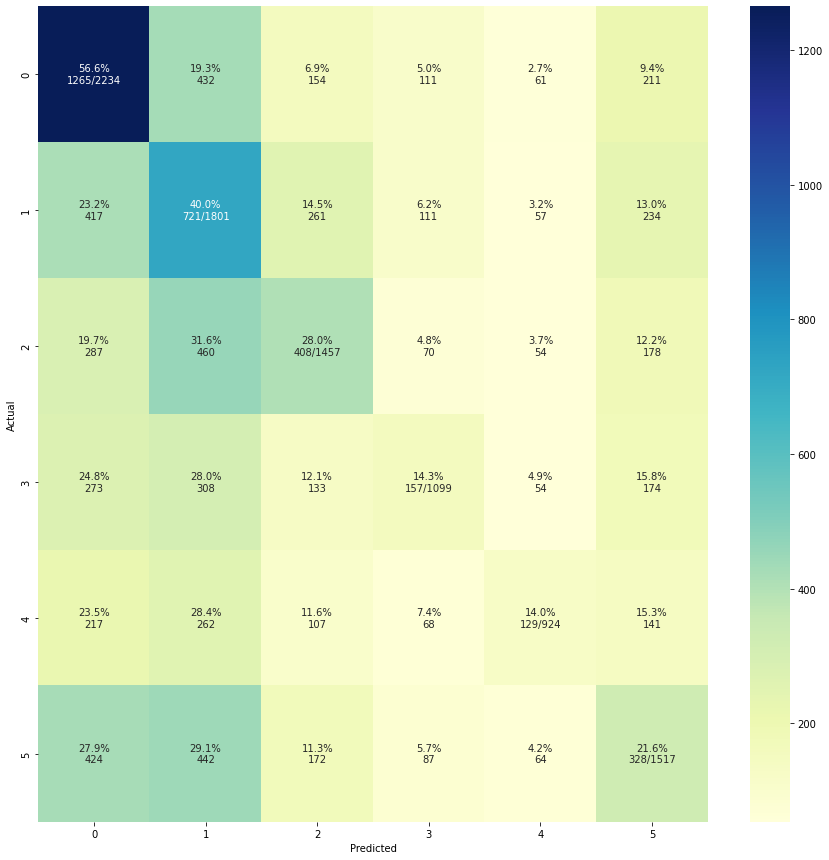

In [ ]:
plot_cm(Count_vectorizer_y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model_lr.predict_proba(Count_vectorizer_x_test)
roc_auc_score(Count_vectorizer_y_test, y_prob, multi_class="ovr",average="macro")

0.6588430214037645

## Naive Bayes with Count Vectorization 

In [ ]:
model = MultinomialNB()
print(cross_val_score(model,Count_vectorizer_x_train,Count_vectorizer_y_train, cv=5).mean())

0.33941396935518314


In [ ]:
# GridSearch with Naive Bayes
def gridsearchNB(clf, X, y):

    #the grid of parameters to search over
    alphas = [0.001,0.01,.1, 1, 5, 10, 50]

    #Find the best value for alpha and min_df, and the best classifier
    best_alpha = None
    maxscore=-np.inf
    for alpha in alphas:        
        clf = MultinomialNB(alpha=alpha)
        cvscore = max(cross_val_score(clf, X,y,cv = 5))
        if cvscore > maxscore:
                maxscore = cvscore 
                best_alpha = alpha
    return  best_alpha, maxscore

print("Best Case with Count Vectorizer: ", gridsearchNB(model,count_vectorizer_df, target_thres))

Best Case with Count Vectorizer:  (5, 0.3562887511071745)


## Accuracy for NB

In [ ]:
from sklearn.metrics import accuracy_score
model = MultinomialNB(alpha=5)
model.fit(Count_vectorizer_x_train,Count_vectorizer_y_train)
save_model(model,"cv-nb-bbt")
y_pred = model.predict(Count_vectorizer_x_test)
accuracy_score(Count_vectorizer_y_test, y_pred)

0.3403454384410983

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model_lr.predict_proba(Count_vectorizer_x_test)
roc_auc_score(Count_vectorizer_y_test, y_prob, multi_class="ovr",average="macro")

0.6588430214037645

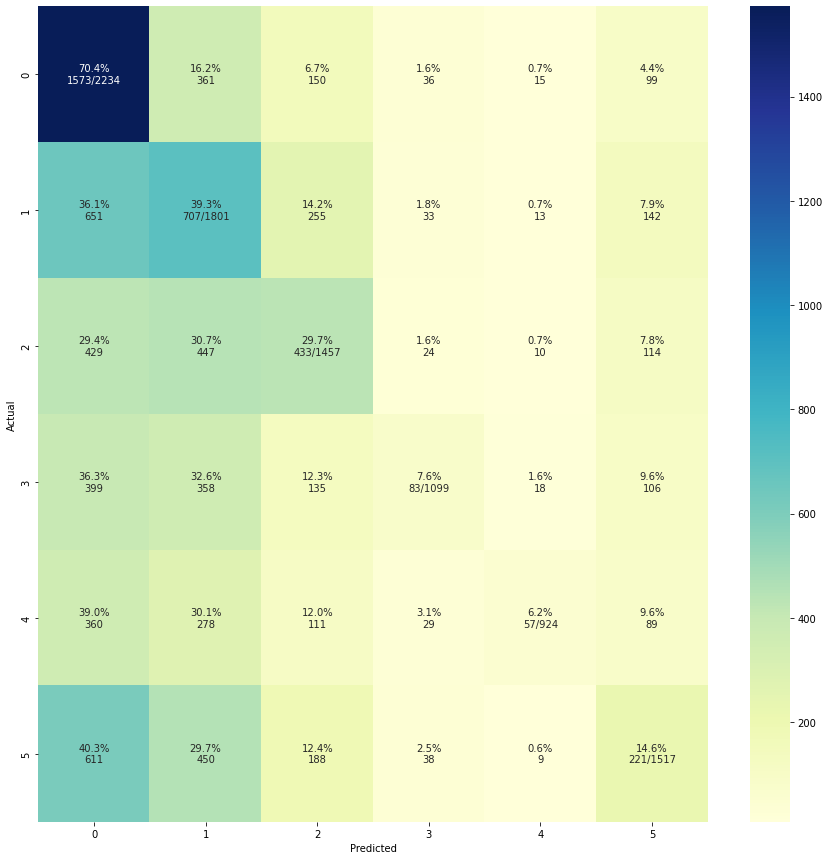

In [ ]:
plot_cm(Count_vectorizer_y_test, y_pred)

## Support Vector Machine: 

In [ ]:
model_svc =SVC()
print('Accuracy of Support Vector Machine without Gridsearch:', cross_val_score(model_svc,Count_vectorizer_x_train,Count_vectorizer_y_train, cv=5).mean())

Accuracy of Support Vector Machine without Gridsearch: 0.3345145605498024


In [ ]:
from sklearn.metrics import accuracy_score
model_svc = SVC(probability=True)
model_svc.fit(Count_vectorizer_x_train,Count_vectorizer_y_train)
save_model(model_svc,"cv-svm-bbt")
y_pred = model_svc.predict(Count_vectorizer_x_test)
accuracy_score(Count_vectorizer_y_test, y_pred)

0.3308237378210806

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model_svc.predict_proba(Count_vectorizer_x_test)
roc_auc_score(Count_vectorizer_y_test, y_prob, multi_class="ovr",average="macro")

0.642428464901588

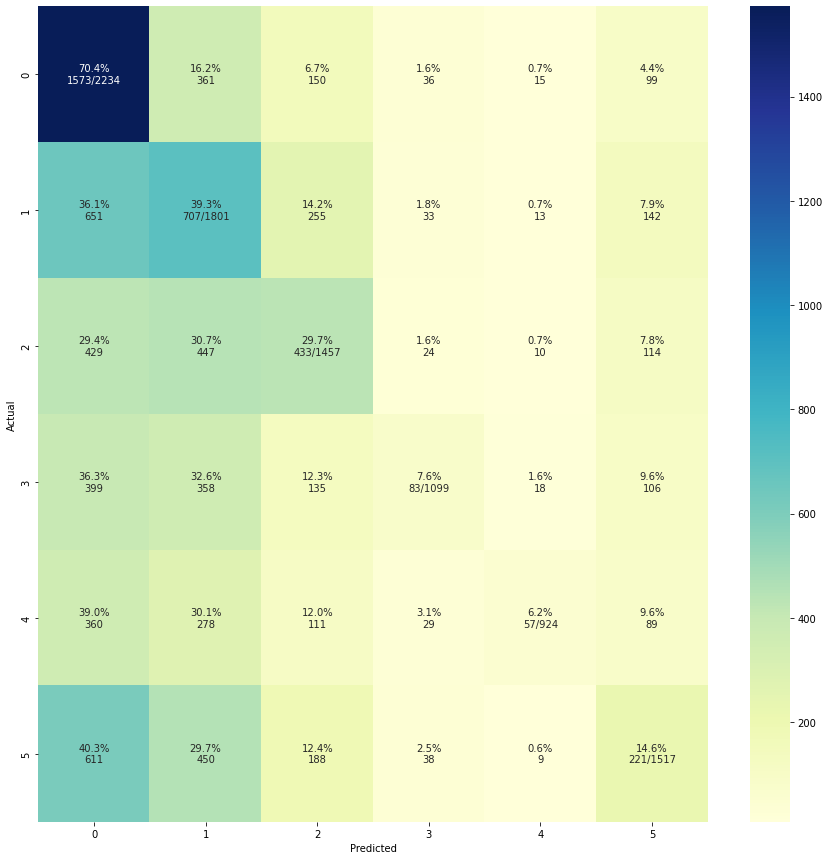

In [ ]:
plot_cm(Count_vectorizer_y_test, y_pred)